In [20]:
import sys

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pyglet
from bindsnet.environment import GymEnvironment
from bindsnet.learning.reward import AbstractReward, MovingAvgRPE
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_weights
from agents import PendulumObserverAgent, ExpertAgent
from pipelines import ToMPipeline

In [24]:
%matplotlib inline

In [25]:
def _compute_spikes(
    datum: torch.Tensor,
    time: int,
    low: float,
    high: float,
    device: str
) -> torch.Tensor:
    times = torch.linspace(low, high, time, device=device)
    spike_times = torch.argmin(torch.abs(datum - times))
    spikes = (np.array(spike_times.to('cpu')).astype(int) ==
              range(0, time)).astype(int)
    reverse_spikes = np.flip(spikes).copy()
    return torch.stack([
        torch.from_numpy(spikes).to(device),
        torch.from_numpy(reverse_spikes).to(device)
    ]).byte()

In [26]:
def pendulum_observation_encoder(
        datum: torch.Tensor,
        time: int,
        **kwargs,
) -> dict:
    """

    Parameters
    ----------
    datum : torch.Tensor
        Observation tensor.
    time : int
        Length of spike train per observation.

    Keyword Arguments
    -----------------

    Returns
    -------
    dict
        The tensor of encoded data per input population.

    """
    device = "cpu" if datum.get_device() < 0 else 'cuda'
    datum = datum.squeeze()
    if (datum.shape[0] == 3):
        cos, sin, velocity = datum
    else:
        theta, velocity = datum
        cos = np.cos(theta)
        sin = np.sin(theta)
    min_cos, max_cos = -1.0, 1.0
    min_sin, max_sin = -1.0, 1.0
    min_velocity, max_velocity = -8.0, 8.0

    cos_spikes = _compute_spikes(cos, time, min_cos, max_cos, device)
    sin_spikes = _compute_spikes(sin, time, min_sin, max_sin, device)
    velocity_spikes = _compute_spikes(velocity, time, min_velocity,
                                      max_velocity, device)

    spikes = torch.stack([cos_spikes, sin_spikes, velocity_spikes]).T
    
    return {"S2": spikes.unsqueeze(1).byte().to(device)}

In [27]:
class PendulumReward(AbstractReward):
    """
    Computes the reward for Pendulum environment.
    Parameters
    ----------
    Keyword Arguments
    -----------------
    """

    def __init__(self, **kwargs):
        self.alpha = 1.0  # reward multiplier
        self.accumulated_rewards = []  # holder of observation evaluations

    def compute(self, **kwargs):
        """
        Compute the reward.
        Keyword Arguments
        -----------------
        reward : float
            The reward value returned from the environment
        """
        reward = kwargs["reward"]
        
        return reward * self.alpha

    def update(self, **kwargs):
        """
        Update internal attributes.
        Keyword Arguments
        -----------------
        accumulated_reward : float
            The value of accumulated reward in the episode.
        """
        accumulated_reward = kwargs.get("accumulated_reward")
        self.accumulated_rewards.append(accumulated_reward)


In [28]:
def _noise_policy(episode, num_episodes, **kwargs):
    return 0

In [29]:
# Define the environment
environment = GymEnvironment('Pendulum-v1', render_mode='human')

In [33]:
# Define observer agent
observer = PendulumObserverAgent(environment, dt=1.0, method='first_spike', reward_fn=PendulumReward)

In [34]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()

        self.fc_1 = nn.Linear(state_dim, 64)
        self.fc_2 = nn.Linear(64, 32)
        self.fc_out = nn.Linear(32, action_dim)
        
    def forward(self, x):
        q = F.leaky_relu(self.fc_1(x))
        q = F.leaky_relu(self.fc_2(q))
        q = self.fc_out(q)
        return q

In [35]:
def expert_forward(state, weight='./DQN_Q_EP490_pendulum.pt', state_dim=3, action_dim=9, **kwargs):
    model = QNetwork(state_dim, action_dim)
    if isinstance(weight, str):
        weight = torch.load(weight)
    model.load_state_dict(weight)
    
    if (state.shape[0] == 2):
        cos1 = np.cos(state[0])
        sin1 = np.sin(state[0])
        vel1 = state[1]
    else:
        cos1, sin1, vel1 = state
    
    obs = torch.Tensor([cos1, sin1, vel1])

    q = model(obs)
    
    action = float(torch.argmax(q).numpy())
    real_action = (action - 4) / 2
    
    return real_action

In [36]:
# Define expert agent acting on pretrained weights (weight is multiplied by
# observation vector)
expert = ExpertAgent(environment, method='user-defined',
                     noise_policy=_noise_policy)

In [37]:
# Define the pipeline by which the agents interact
pipeline = ToMPipeline(
    observer_agent=observer,
    expert_agent=expert,
    encoding=pendulum_observation_encoder,
    time=15,
    num_episodes=200,
    representation_time=7,
    log_writer = True,
    output_shape = 9,
    render_interval=5,
)

In [38]:
pipeline.observe_learn(function=expert_forward, weight='./DQN_Q_EP490_pendulum.pt',
                       test_interval=15, num_tests=7, state_dim=3, action_dim=9)
print("Observation Finished")

Episode: 0 - accumulated reward: -130.66
Episode: 1 - accumulated reward: -130.49
Episode: 2 - accumulated reward: -129.91
Episode: 3 - accumulated reward: -8.62
Episode: 4 - accumulated reward: -131.52
Episode: 5 - accumulated reward: -6.02
Episode: 6 - accumulated reward: -127.61
Episode: 7 - accumulated reward: -280.39
Episode: 8 - accumulated reward: -125.09
Episode: 9 - accumulated reward: -131.16
Episode: 10 - accumulated reward: -131.17
Episode: 11 - accumulated reward: -129.46
Episode: 12 - accumulated reward: -244.16
Episode: 13 - accumulated reward: -130.60
Episode: 14 - accumulated reward: -246.04
Test - accumulated reward: -1207.3238073289751
Test - accumulated reward: -1247.0259510512656
Test - accumulated reward: -1406.6961219867642
Test - accumulated reward: -1214.1038167728143
Test - accumulated reward: -1146.6862673069952
Test - accumulated reward: -1341.7344552018797
Test - accumulated reward: -1170.3315354038366
Episode: 15 - accumulated reward: -6.63
Episode: 16 - a

Episode: 134 - accumulated reward: -130.66
Test - accumulated reward: -1506.1441577433106
Test - accumulated reward: -1371.3943056002445
Test - accumulated reward: -1512.646562001726
Test - accumulated reward: -1377.0427114089623
Test - accumulated reward: -1577.5364570534578
Test - accumulated reward: -1567.9489285500438
Test - accumulated reward: -1529.0221910382193
Episode: 135 - accumulated reward: -132.64
Episode: 136 - accumulated reward: -248.60
Episode: 137 - accumulated reward: -130.59
Episode: 138 - accumulated reward: -134.65
Episode: 139 - accumulated reward: -128.57
Episode: 140 - accumulated reward: -8.39
Episode: 141 - accumulated reward: -5.06
Episode: 142 - accumulated reward: -126.17
Episode: 143 - accumulated reward: -134.00
Episode: 144 - accumulated reward: -232.57
Episode: 145 - accumulated reward: -8.20
Episode: 146 - accumulated reward: -130.16
Episode: 147 - accumulated reward: -126.93
Episode: 148 - accumulated reward: -125.88
Episode: 149 - accumulated reward

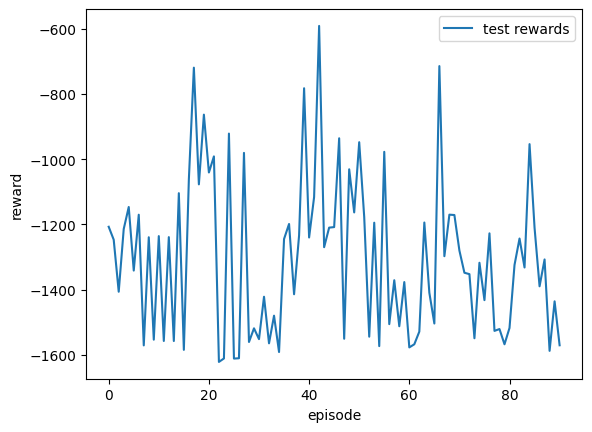

In [39]:
plt.plot(pipeline.test_rewards, label='test rewards')
plt.xlabel("episode")
plt.ylabel("reward")
plt.legend()
plt.savefig(f"test_rewards_{12_10}.png")

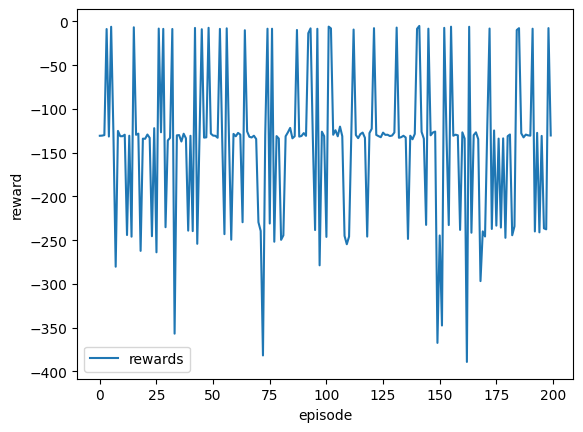

In [40]:
plt.plot(pipeline.reward_list, label='rewards')
plt.xlabel("episode")
plt.ylabel("reward")
plt.legend()
plt.savefig(f"rewards_{12_10}.png")